<a href="https://colab.research.google.com/github/bukhtiar-haider/bert-multi-label-classification/blob/main/bert_multilabel_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multilabel Classification for CelebA Attributes

This notebook explores the task of multilabel classification for the CelebA dataset, which contains 202,599 images of celebrity faces, each annotated with 40 binary attributes such as "smiling", "wearing lipstick", and "eyeglasses". The goal is to fine-tune a large language model to take a sentence as input and output a feature vector of x features that describe the attributes of the face in the image.

The notebook includes the following sections:

- Data Loading and Preprocessing: Loads the CelebA dataset, performs exploratory data analysis (EDA), and preprocesses the data to prepare it for modeling.
- Synonym Generation: Takes a dictionary of synonymous words for each attribute to handle variations in how attributes are expressed.
- Dataset Creation: Creates a corpus of sentences using synonyms to serve as the training data for the multilabel classifier.
- Model Training and Evaluation: Fine-tunes a large language model on the dataset, evaluates its performance using various metrics, and interprets the results.
- Conclusion and Future Work: Summarizes the findings and suggests potential avenues for future work.

The notebook uses Python and popular libraries such as pandas, NLTK, and Transformers to implement the solution. The code is well-documented, and the results are presented with clear visualizations and explanations.


In [ ]:
!pip install nltk
!pip install transformers

In [ ]:
import csv
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import nltk
from PIL import Image
from tqdm import tqdm
from scipy.spatial.distance import cosine
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, BertTokenizer, BertModel, TrainingArguments, Trainer
from datasets import DatasetDict, Dataset

## Loading the data

We also change the features to a categorical (0, 1) representation from (-1, 1)

In [ ]:
# Load the CSV file
df = pd.read_csv("list_attr_celeba.csv")

# Change the representation to categorical
df.iloc[:, 1:] = df.iloc[:, 1:].replace(-1, 0).astype('category')
df.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,0,1,1,0,0,0,0,0,0,...,0,1,1,0,1,0,1,0,0,1
1,000002.jpg,0,0,0,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
2,000003.jpg,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
3,000004.jpg,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,1,1,0,1
4,000005.jpg,0,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,1


## Viewing data types and column names

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202599 entries, 0 to 202598
Data columns (total 41 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   image_id             202599 non-null  object  
 1   5_o_Clock_Shadow     202599 non-null  category
 2   Arched_Eyebrows      202599 non-null  category
 3   Attractive           202599 non-null  category
 4   Bags_Under_Eyes      202599 non-null  category
 5   Bald                 202599 non-null  category
 6   Bangs                202599 non-null  category
 7   Big_Lips             202599 non-null  category
 8   Big_Nose             202599 non-null  category
 9   Black_Hair           202599 non-null  category
 10  Blond_Hair           202599 non-null  category
 11  Blurry               202599 non-null  category
 12  Brown_Hair           202599 non-null  category
 13  Bushy_Eyebrows       202599 non-null  category
 14  Chubby               202599 non-null  category
 15  

## Number of null counts per column

In [ ]:
print(df.isna().sum())

image_id               0
5_o_Clock_Shadow       0
Arched_Eyebrows        0
Attractive             0
Bags_Under_Eyes        0
Bald                   0
Bangs                  0
Big_Lips               0
Big_Nose               0
Black_Hair             0
Blond_Hair             0
Blurry                 0
Brown_Hair             0
Bushy_Eyebrows         0
Chubby                 0
Double_Chin            0
Eyeglasses             0
Goatee                 0
Gray_Hair              0
Heavy_Makeup           0
High_Cheekbones        0
Male                   0
Mouth_Slightly_Open    0
Mustache               0
Narrow_Eyes            0
No_Beard               0
Oval_Face              0
Pale_Skin              0
Pointy_Nose            0
Receding_Hairline      0
Rosy_Cheeks            0
Sideburns              0
Smiling                0
Straight_Hair          0
Wavy_Hair              0
Wearing_Earrings       0
Wearing_Hat            0
Wearing_Lipstick       0
Wearing_Necklace       0
Wearing_Necktie        0


## Check for data imbalance

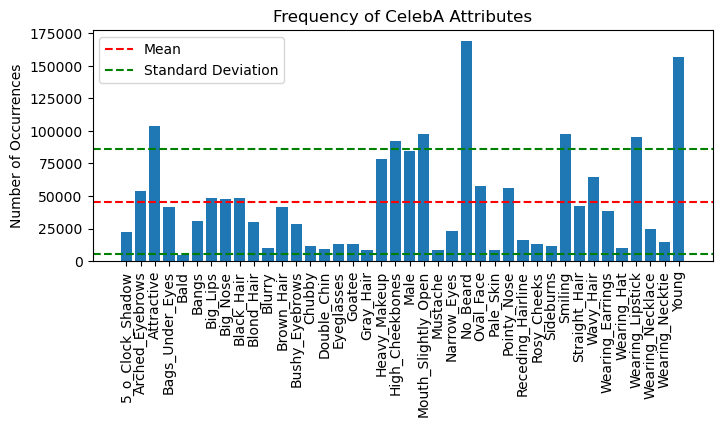

In [ ]:
# Calculate the number of occurrences for each feature
feature_counts = df.iloc[:, 1:].apply(pd.Series.value_counts).loc[1]
mean_counts = feature_counts.mean()
std_counts = feature_counts.std()

# Plot the results
fig, ax = plt.subplots(figsize=(8, 3))
ax.bar(feature_counts.index, feature_counts.values)
ax.axhline(mean_counts, color='r', linestyle='--', label='Mean')
ax.axhline(mean_counts + std_counts, color='g', linestyle='--', label='Standard Deviation')
ax.axhline(mean_counts - std_counts, color='g', linestyle='--')
ax.set_xticks(range(len(feature_counts.index)))
ax.set_xticklabels(feature_counts.index, rotation=90)
ax.set_ylabel('Number of Occurrences')
ax.set_title('Frequency of CelebA Attributes')
ax.legend()
plt.show()

## Load synonyms dictionary

The synonym dictionary was created using GPT3

In [ ]:
# Load the CSV file as a dictionary
synonyms_dict = {}
with open('synonyms_dict.csv', 'r') as file:
    reader = csv.reader(file)
    for row in reader:
        synonyms_dict[row[0]] = row[1:]
# Replace underscores with spaces in the keys
synonyms_dict = {k.replace('_', ' '): v for k, v in synonyms_dict.items()}

### Define a function to select attributes from the synonyms dictionary.

In [ ]:
def select_attributes(synonyms_dict):
    # Select a random number of attributes
    num_attributes = random.randint(1, len(synonyms_dict))
    attributes = random.sample(list(synonyms_dict), num_attributes)

    # Create a selection vector for each attribute
    selection_vector = []
    for attribute in synonyms_dict:
        if attribute in attributes:
            selection_vector.append(1)
        else:
            selection_vector.append(0)

    # Select a random synonym for each attribute
    selected_synonyms = []
    for attribute in attributes:
        synonyms = synonyms_dict[attribute]
        selected_synonym = random.choice(synonyms)
        selected_synonyms.append(selected_synonym)

    # Shuffle to remove any positional dependance
    random.shuffle(selected_synonyms)
    
    selection_vector = [float(x) for x in selection_vector]
    
    return attributes, selection_vector, selected_synonyms

### Define a function to generate a sentence with the selected attributes

In [ ]:
def generate_sentence(synonyms_dict):
    # Select attributes and synonyms
    attributes, selection_vector, selected_synonyms = select_attributes(synonyms_dict)

    # Define the template sentence
    template = "Description of person: {}."

    # Use the selected synonyms to generate the sentence
    attributes = []
    for synonym in selected_synonyms:
        for key, value in synonyms_dict.items():
            if synonym in value:
                attributes.append(key)
                break
    sentence = template.format(", ".join(attributes))
    
    return sentence, selection_vector

### Define a function to generate the dataset of sentences and their corresponding labels

In [ ]:
def generate_dataset(num_sentences, synonyms_dict):
    sentences = []
    feature_labels = []
    for i in range(num_sentences):
        sentence, selection_vector = generate_sentence(synonyms_dict)
        sentences.append(sentence)
        feature_labels.append(selection_vector)
    return sentences, feature_labels

### Generate sentences and create a Dataset

In [ ]:
# Generate sentences with their corresponding labels
sentences, labels = generate_dataset(10000, synonyms_dict)

# Concatenate the sentence with the label
for i in range (len(labels)):
    labels[i].insert(0, sentences[i])
    
# Prepare list of column names
columns = list(df.columns)
columns[0] = 'sentence'

# Create Dataset from two parallel lists
data = {name: column for name, column in zip(columns, zip(*labels))}
dataset = Dataset.from_dict(data)

# Split dataset into train and test subsets
train_frac, test_frac = 0.8, 0.2
dataset_dict = dataset.train_test_split(test_size=0.2)

### Define functions to map labels to integers and back 

In [ ]:
labels = [label for label in dataset_dict['test'].features.keys() if label not in ['sentence']]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

### Define a function to preprocess data

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

def preprocess_data(examples):
  # take a batch of texts
  text = examples["sentence"]
  # encode them
  encoding = tokenizer(text, padding="max_length", truncation=True, max_length=128)
  # add labels
  labels_batch = {k: examples[k] for k in examples.keys() if k in labels}
  # create numpy array of shape (batch_size, num_labels)
  labels_matrix = np.zeros((len(text), len(labels)))
  # fill numpy array
  for idx, label in enumerate(labels):
    labels_matrix[:, idx] = labels_batch[label]

  encoding["labels"] = labels_matrix.tolist()
  
  return encoding

In [ ]:
encoded_dataset = dataset_dict.map(preprocess_data, batched=True, remove_columns=dataset_dict['train'].column_names)

encoded_dataset.set_format("torch")

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

### Define Model

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", 
                                                           problem_type="multi_label_classification", 
                                                           num_labels=len(labels),
                                                           id2label=id2label,
                                                           label2id=label2id)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

### Define training arguments

In [ ]:
batch_size = 32
metric_name = "accuracy"

In [ ]:
args = TrainingArguments(
    f"bert-finetuned-sem_eval-english",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-4,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=10,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    #push_to_hub=True,
)

### Define evaluation metrics

In [ ]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
    
# source: https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p.label_ids)
    return result

### Finetune the model

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train()

C:\Users\bukht\AppData\Roaming\Python\Python39\site-packages\transformers\optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,No log,0.482539,0.766223,0.760046,0.030000
2,0.465300,0.231713,0.928978,0.924492,0.090500
3,0.465300,0.077085,0.988620,0.988219,0.618500
4,0.105100,0.052906,0.990711,0.990274,0.741000
5,0.105100,0.042617,0.990779,0.990424,0.753000
6,0.045800,0.037894,0.990722,0.990461,0.752500
7,0.045800,0.035263,0.991094,0.990803,0.784000
8,0.033200,0.033252,0.990869,0.990550,0.767500
9,0.033200,0.032537,0.990760,0.990437,0.759500
10,0.026100,0.032290,0.990806,0.990495,0.771000


TrainOutput(global_step=2500, training_loss=0.13508368110656738, metrics={'train_runtime': 47604.0525, 'train_samples_per_second': 1.681, 'train_steps_per_second': 0.053, 'total_flos': 5264016506880000.0, 'train_loss': 0.13508368110656738, 'epoch': 10.0})

### Test the model on a new sentence

In [ ]:
text = "A beautiful blonde woman with wavy hair, glasses, lipstick, and a necklace"

encoding = tokenizer(text, return_tensors="pt")
encoding = {k: v.to(trainer.model.device) for k,v in encoding.items()}

outputs = trainer.model(**encoding)
logits = outputs.logits

In [ ]:
# apply sigmoid + threshold
sigmoid = torch.nn.Sigmoid()
probs = sigmoid(logits.squeeze().cpu())
predictions = np.zeros(probs.shape)
predictions[np.where(probs >= 0.5)] = 1
# turn predicted id's into actual label names
predicted_labels = [id2label[idx] for idx, label in enumerate(predictions) if label == 1.0]
print(predicted_labels)

['Attractive', 'Blond_Hair', 'Wavy_Hair', 'Wearing_Lipstick', 'Wearing_Necklace']


### Retreive the image with the features
This assumes you have the celeba dataset images on your local storage. Set the relevant filepath.

In [ ]:
df_no_id = df.drop(columns=["image_id"])

min_distance = np.inf
min_index = None

for i, row in df_no_id.iterrows():
    distance = cosine(row.values, predictions)
    if distance < min_distance:
        min_distance = distance
        min_index = i
        if min_distance == 0:
            break

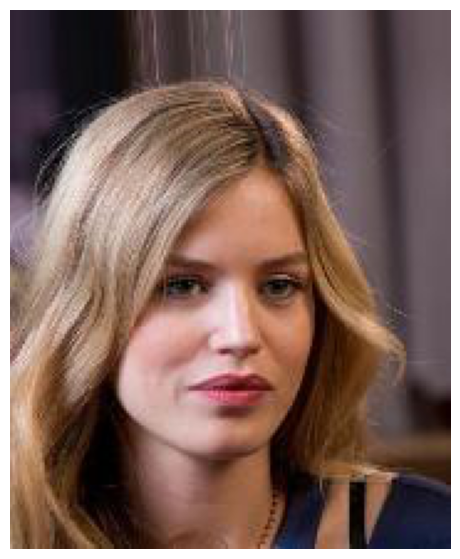

In [ ]:
image_name = df["image_id"][min_index]

# Define your own image path here
file_path = "" + image_name

# Opening the image using PIL
image = Image.open(file_path)

# Converting PIL image to numpy array
image_array = np.array(image)

# Displaying image with matplotlib
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(image)
ax.set_axis_off()
plt.show()